# 집값 예측 경진대회

# 데이터 불러오기

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

path = 'data/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')
train.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


이 코드를 그대로 사용하신다면 path 위치를 파일 저장하신 곳으로 지정하시면 됩니다.

In [51]:
print(train.shape)
print(test.shape) #target이 없으므로

(1350, 15)
(1350, 14)


학습 데이터, 테스트 데이터 모두 1350개이며 변수는 총 14개입니다.

In [52]:
train.info() #앞에서 본 isnu 메소드를 쓴 함수를 대체하는 info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1350 non-null   int64 
 1   Overall Qual    1350 non-null   int64 
 2   Gr Liv Area     1350 non-null   int64 
 3   Exter Qual      1350 non-null   object
 4   Garage Cars     1350 non-null   int64 
 5   Garage Area     1350 non-null   int64 
 6   Kitchen Qual    1350 non-null   object
 7   Total Bsmt SF   1350 non-null   int64 
 8   1st Flr SF      1350 non-null   int64 
 9   Bsmt Qual       1350 non-null   object
 10  Full Bath       1350 non-null   int64 
 11  Year Built      1350 non-null   int64 
 12  Year Remod/Add  1350 non-null   int64 
 13  Garage Yr Blt   1350 non-null   int64 
 14  target          1350 non-null   int64 
dtypes: int64(12), object(3)
memory usage: 158.3+ KB


결측치는 없는 것으로 관찰됩니다.

# 타겟 변수 관찰

회귀 문제를 다룰때는 개인적인 경험으로 타겟 변수의 분포가 상당히 중요하다고 생각하기 때문에 가장 먼저 살펴보는 편 입니다.

이 데이터의 타겟 변수는 집값 변수입니다. 특이한 이상치가 없는지, 정규분포와 유사한 모양을 따르는지를 중점적으로 관찰하겠습니다. 

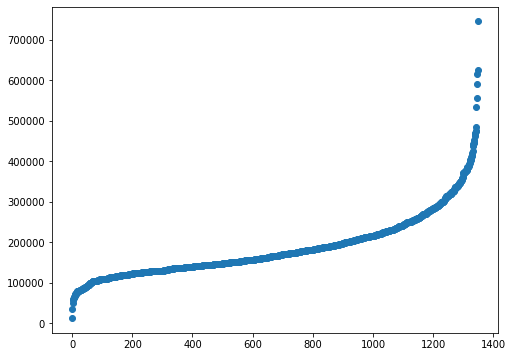

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['target'].values))
plt.show()

집값을 크기순으로 정렬한 뒤 그래프로 관찰했습니다. 

과하게 0과 가까운 점이 하나 관찰되고, 50만보다 큰 데이터 또한 띄엄띄엄 관찰됩니다.

데이터 크기가 거대하지 않기 때문에 과연 이상치인지 다른 변수를 살펴본 뒤 다시 관찰하겠습니다.

<AxesSubplot:xlabel='target', ylabel='Density'>

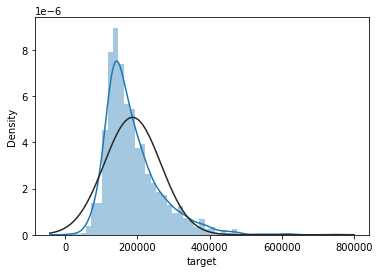

In [54]:
sns.distplot(train['target'], fit=stats.norm)

타겟 변수의 정규성에 대해서 살펴봤습니다. 파란색이 실제 데이터의 히스토그램이고 검은색이 정규분포임을 가정한 그래프입니다.

확실히 오른쪽 꼬리가 긴 모습인데, 집 값 데이터임을 감안하고 보면 납득이 되는 결과입니다.

하지만 데이터 분석을 할때는 다소 부적절할 것 같아서 로그변환을 적극적으로 검토해보겠습니다.

<AxesSubplot:xlabel='target', ylabel='Density'>

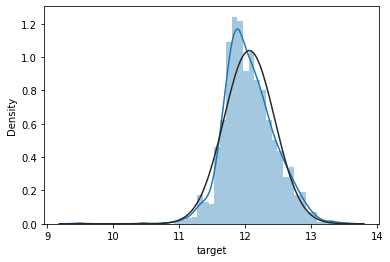

In [55]:
sns.distplot(np.log1p(train['target']), fit=stats.norm)

타겟 변수를 로그변환한 뒤 정규성을 확인했습니다. 이전보다 확실히 정규분포에 가깝습니다.

다만 이전에 관찰한 0과 가까운 집값 데이터 때문인지 9 근처에 데이터 하나가 잡히는게 신경쓰이네요.

# 이산형 변수 관찰

# Overall Qual 변수

In [56]:
train['Overall Qual'].value_counts() #값 카운트

5     379
6     351
7     307
8     156
4      75
9      56
10     15
3       8
2       3
Name: Overall Qual, dtype: int64

Overall Qual 변수는 전반적 재료와 마감품질 변수입니다.

이 변수는 2부터 10까지 값으로 표현되어있으며 중앙값인 5,6,7에 변수들이 몰려있는 걸 알 수 있습니다.

제가 아는 통계이론으로, 개수가 30 이하의 범주는 병합하는 것이 좋기 때문에 병합을 생각하고 그래프를 그려보겠습니다.

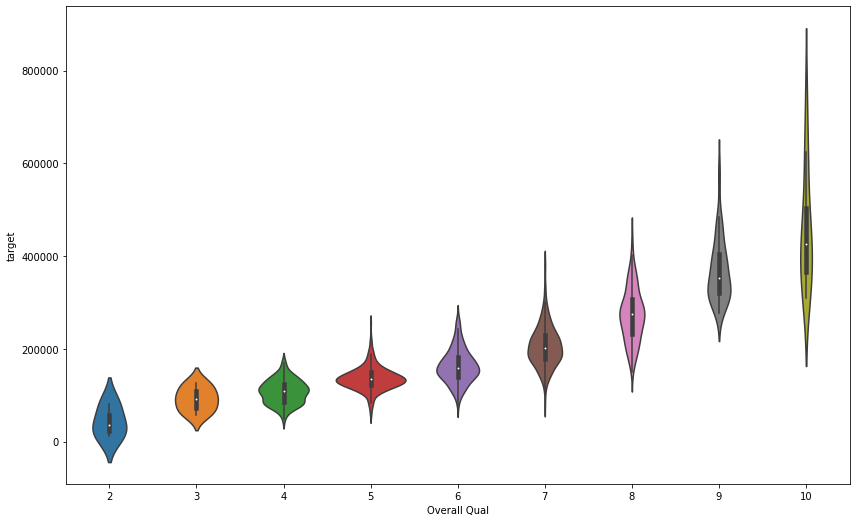

In [57]:
def discrete_plot(variable):    
    plt.figure(figsize=(12,8))
    sns.violinplot(x= train[variable], y= train['target'])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

discrete_plot('Overall Qual')

Overall Qual 변수는 재료 품질변수이기 때문에 값이 클 수록 집 값의 분포 또한 높게 나오는 걸 쉽계 예측할 수 있습니다.

예측한 것과 실제 데이터가 일치한 지를 시각화를 해보았습니다. 예상한 결과와 크게 다르지 않습니다.

또한 변수 값이 커질수록 박스 플랏이 길어진다, 즉 분산이 커지는 것도 관찰할 수 있습니다.

앞서 말한대로 표본 개수가 적은 2,3 그리고 10 항목은 4와 9 항목과 병합하겠습니다.

이때 테스트 데이터의 정확한 항목을 모르기 때문에 코딩은 9 이상 값은 9로, 4이하 값은 4로 하겠습니다.

이후 연속형 변수들을 표준화 할 것이기 때문에 이 변수도 평균을 0과 근사하게 하기 위해 모든 값을 6.5로 빼주겠습니다.

In [58]:
train['Overall Qual'][train['Overall Qual'] > 9] = 9
train['Overall Qual'][train['Overall Qual'] < 4] = 4
train['Overall Qual'] = train['Overall Qual'] - 6.5

test['Overall Qual'][test['Overall Qual'] > 9] = 9
test['Overall Qual'][test['Overall Qual'] < 4] = 4
test['Overall Qual'] = test['Overall Qual'] - 6.5

# Exter Qual 변수

In [59]:
train['Exter Qual'].value_counts()

TA    808
Gd    485
Ex     49
Fa      8
Name: Exter Qual, dtype: int64

In [60]:
test['Exter Qual'].value_counts()

TA    794
Gd    489
Ex     58
Fa      9
Name: Exter Qual, dtype: int64

Exter Qual변수는 외관 재료 품질 변수입니다. 4등급으로 나눠진 것 같아요.

구체적으로 Fair -> Typical/Average -> Good -> Excellent 순인 것 같습니다. (yun99님 코드 공유 내용을 참고했습니다.)

TA, Gd. 중간 부분 등급이 많이 관찰된 모습입니다. 다만 Fa는 8개로 표본 개수가 많이 부족해보입니다.



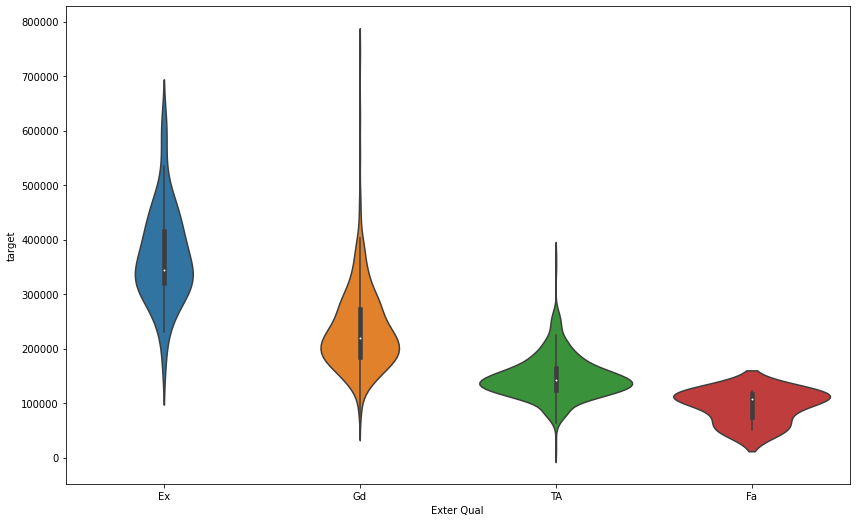

In [61]:
discrete_plot('Exter Qual')

앞서 언급한 등급 순서대로 집값이 높은 것을 관찰할 수 있습니다. 예상한 결과와 같죠.

Fa 항목이 표본이 작아 걱정됬는데 합리적인 결과가 나오긴 한 것 같아요. 

하지만 TA 항목과 큰 차이가 없기 때문에 항목 개수를 줄여준다는 차원에서 두 항목을 병합하겠습니다.

In [62]:
mapping={'Ex':1, 'Gd':0, 'TA':-1, 'Fa':-1, 'Po':-1}

train['Exter Qual'] = train['Exter Qual'].map(mapping)
test['Exter Qual'] = test['Exter Qual'].map(mapping)

(jujukwakwkak님의 코드 공유 내용을 참고했습니다.)

범주형 값이기 때문에 분석 가능한 숫자 값으로 변환했습니다. 좋은 항목일 수록 큰 값을 배치했는데 일종의 라벨-인코딩입니다.

추후에 연속형 변수들을 표준화 할 예정이기 때문에 이 변수도 표준화된 값과 비슷한 형태를 유지하기 위해 값을 1, 0, -1 값을 썼습니다.

또한 Ta보다 아랫 등급의 항목들은 앞서 설명한 대로 Ta와 같은 값으로 취급했습니다.

# Garage Cars 변수

In [63]:
train['Garage Cars'].value_counts()

2    794
1    372
3    172
4     11
5      1
Name: Garage Cars, dtype: int64

Garage Cars 변수는 차고 자리 개수를 나타냅니다. 2대가 보편적인 값으로 보입니다.

0이 없는걸로 봐서 표본에 있는 집은 모두 차고지가 있는 집인 것 같아요. 우리나라랑 주택 환경이 다른것 같습니다.

4, 5 값은 표본이 많이 작기 때문에 값이 튈 수 있습니다. 1대, 2대, 3대 이상 방식으로 범주를 병합하는게 좋겠습니다.

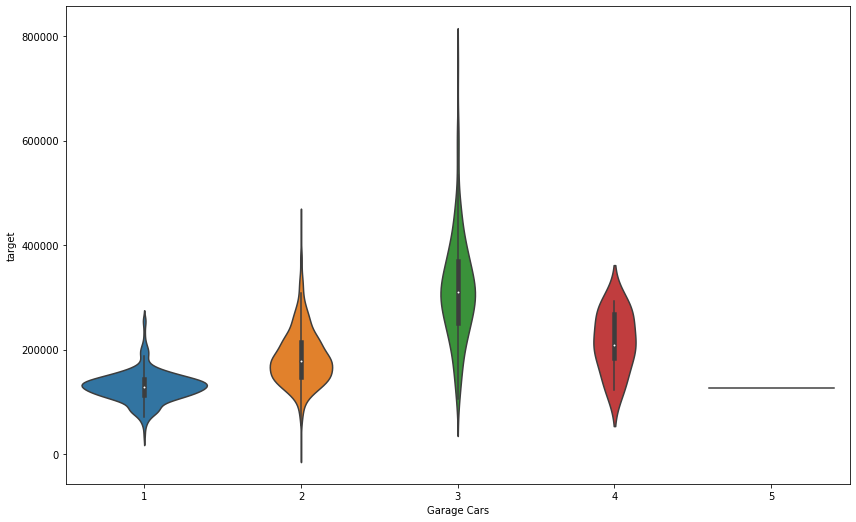

In [64]:
discrete_plot('Garage Cars')

차고 자리 개수가 많을 수록 더 높은 집값을 가지는 것 같아요. 우리가 쉽게 예측할 수 있는 결과입니다.

4,5 항목은 개수가 11개, 1개로 작기 때문에 값이 튀었다고 생각하고 3 항목에 포함시키는 방향이 맞을 것 같습니다.

In [65]:
train['Garage Cars'][train['Garage Cars'] > 3] = 3
train['Garage Cars'] = train['Garage Cars'] - 2

test['Garage Cars'][test['Garage Cars'] > 3] = 3
test['Garage Cars'] = test['Garage Cars'] - 2

테스트 데이터에 어느 값이 있을 지 모르기 때문에 (5보다 큰 값이 있을수도) 그 부분을 고려하여 코딩했습니다.

마찬가지로 평균을 0에 근사시키기 위해 전체 값에 2를 빼주었습니다.

# Kitchen Qual 변수

In [66]:
train['Kitchen Qual'].value_counts()

TA    660
Gd    560
Ex    107
Fa     23
Name: Kitchen Qual, dtype: int64

In [67]:
test['Kitchen Qual'].value_counts()

TA    666
Gd    566
Ex     94
Fa     23
Po      1
Name: Kitchen Qual, dtype: int64

Kitchen Qual 변수는 부엌 품질 변수입니다. 앞서 다룬 외관 품질 변수와 항목이 같습니다.

이 변수 또한 중간 등급의 개수가 많이 나왔습니다. 반면 최하 등급인 Fa 항목은 23개로 개수가 많이 낮습니다.

테스트 데이터에서 특이하게 Po 항목이 1개 있는데 'poor'로 Fa보다 낮은 등급이라고 생각하고 Fa 항목과 같이 취급하겠습니다.

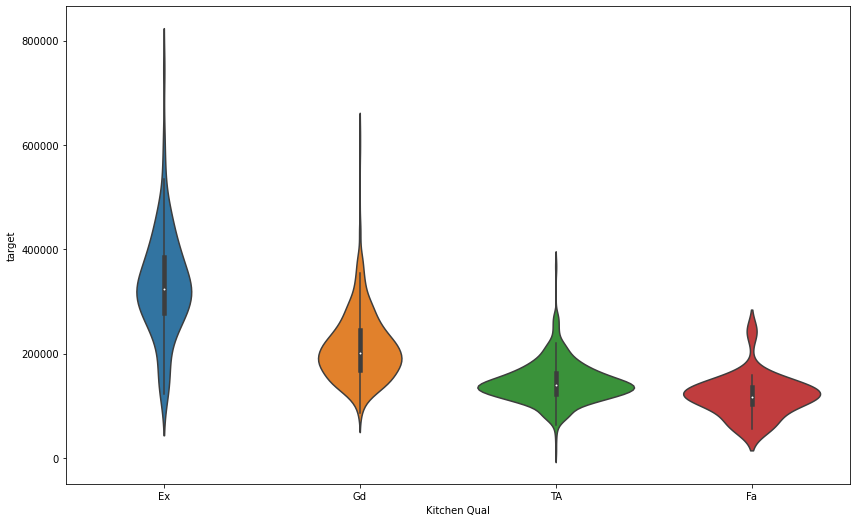

In [68]:
discrete_plot('Kitchen Qual')

앞선 변수와 마찬가지로 품질이 좋을 수록 집값이 더 높게 나오는 쉽게 예측 가능한 결과가 나왔습니다.

Fa 항목의 개수가 23개로 작은 편인데 윗 등급인 TA와 모양에 큰 차이가 없으므로 두 항목을 병합하겠습니다.

In [69]:
mapping={'Ex':1, 'Gd':0, 'TA':-1, 'Fa':-1, 'Po':-1}

train['Kitchen Qual'] = train['Kitchen Qual'].map(mapping)
test['Kitchen Qual'] = test['Kitchen Qual'].map(mapping)

# Bsmt Qual 변수

In [70]:
train['Bsmt Qual'].value_counts()

TA    605
Gd    582
Ex    134
Fa     28
Po      1
Name: Bsmt Qual, dtype: int64

Bsmt Qual 변수는 지하실 높이를 나타내는 변수라고 소개되어있으나 윗 품질 변수와 마찬가지로 생각하면 될 것 같습니다.

저는 지하실 품질이라고 생각하고 변수를 분석하겠습니다.

마찬가지로 중간품질의 개수가 많으며 Fa, Po 항목이 28개, 1개로 개수가 많이 적은 모습입니다.

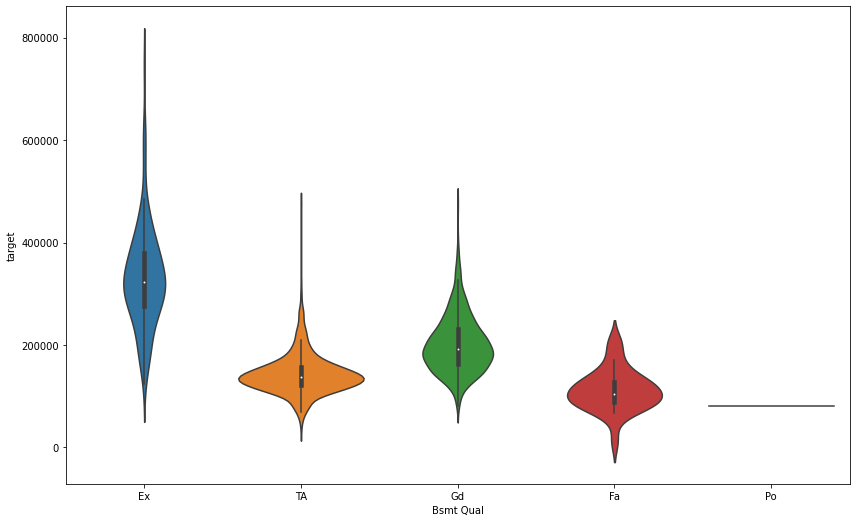

In [71]:
discrete_plot('Bsmt Qual')

계속 비슷한 얘기를 하는 것 같은데 품질이 높을 수록 집값이 비싼 쉽계 예측되는 결과를 보여줍니다.

Ta 항목과 Fa, Po 항목간 값의 차이가 크진 않다고 생각해서 항목의 개수가 작은 Fa, Po 항목은 Ta 항목과 병합하겠습니다.

In [72]:
mapping={'Ex':1, 'Gd':0, 'TA':-1, 'Fa':-1, 'Po':-1}

train['Bsmt Qual'] = train['Bsmt Qual'].map(mapping)
test['Bsmt Qual'] = test['Bsmt Qual'].map(mapping)

# Full Bath 변수

In [73]:
train['Full Bath'].value_counts()

2    703
1    612
3     27
0      6
4      2
Name: Full Bath, dtype: int64

Full Bath 변수는 지상층 화장실 개수 변수 입니다. 한국 집과 비슷하게 화장실이 1, 2개인 집이 대부분이네요.

화장실이 3개있는 집이 27개로 꽤 적은 표본 개수이며 4개 혹은 0개 있는 집의 개수는 각각 6개/2개로 표본이 매우 적습니다.

표본이 적은 항목은 병합을 해주는 것이 분석에도 용이하고 직관성도 올라가기 때문에 병합을 고려하고 밑 그래프로 값을 관찰하겠습니다.

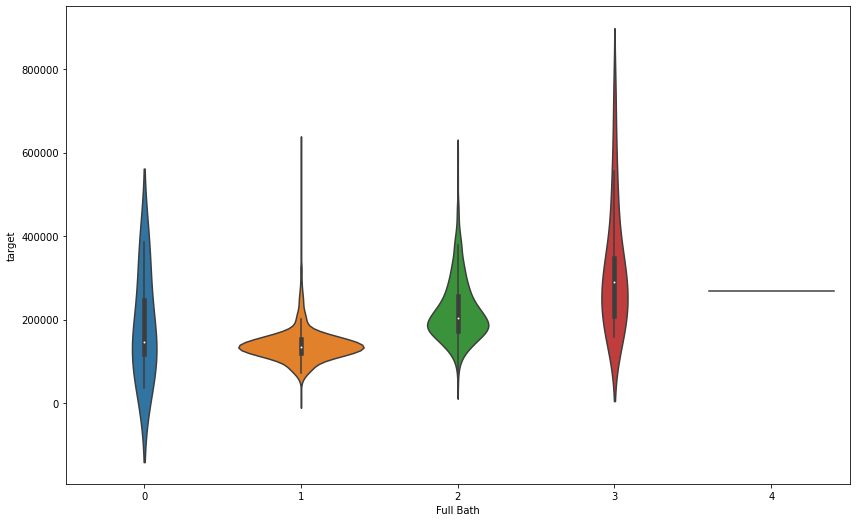

In [74]:
discrete_plot('Full Bath')

우선 표본이 많은 화장실 개수가 1개, 2개인 두 항목의 집값을 비교해보면 직관적 관찰로는 화장실이 2개인 집이 유의미하게 집값이 비싼 것 같아요.

큰 차이는 아닙니다만, 표본에 개수가 6~7백개인데 저정도 차이면 아마 통계적 가설검정을 한다면 꽤 유의미한 수치일 것입니다.

0개, 3개, 4개인 항목또한 화장실 개수가 많아질수록 집 값의 평균값이 증가하는게 보이지만, 표본에 개수가 많이 작죠.

0 항목은 1 항목과, 2보다 큰 항목은 2 항목과 병합을 하겠습니다. 테스트 데이터에 4보다 큰 값이 있을 수 있으니 유의해서 코딩하겠습니다.

또한 평균을 0에 근사시키기 위해 값을 -1과 1로 두겠습니다.


In [75]:
train['Full Bath'][train['Full Bath'] <= 1] = -1
train['Full Bath'][train['Full Bath'] >= 2] = 1

test['Full Bath'][test['Full Bath'] <= 1] = -1
test['Full Bath'][test['Full Bath'] >= 2] = 1

# 연속형 변수 관찰

# 연속형 변수 히스토그램

연속형 변수는 총 7개로 지상층 면적, 차고 면적, 지하층 면적, 1층 면적, 완공 연도, 리모델링 연도, 차고 완공 연도 로 구성되어 있습니다.

크게 4개의 면적과 3개의 연도로 구분할 수 있을 것 같아요.

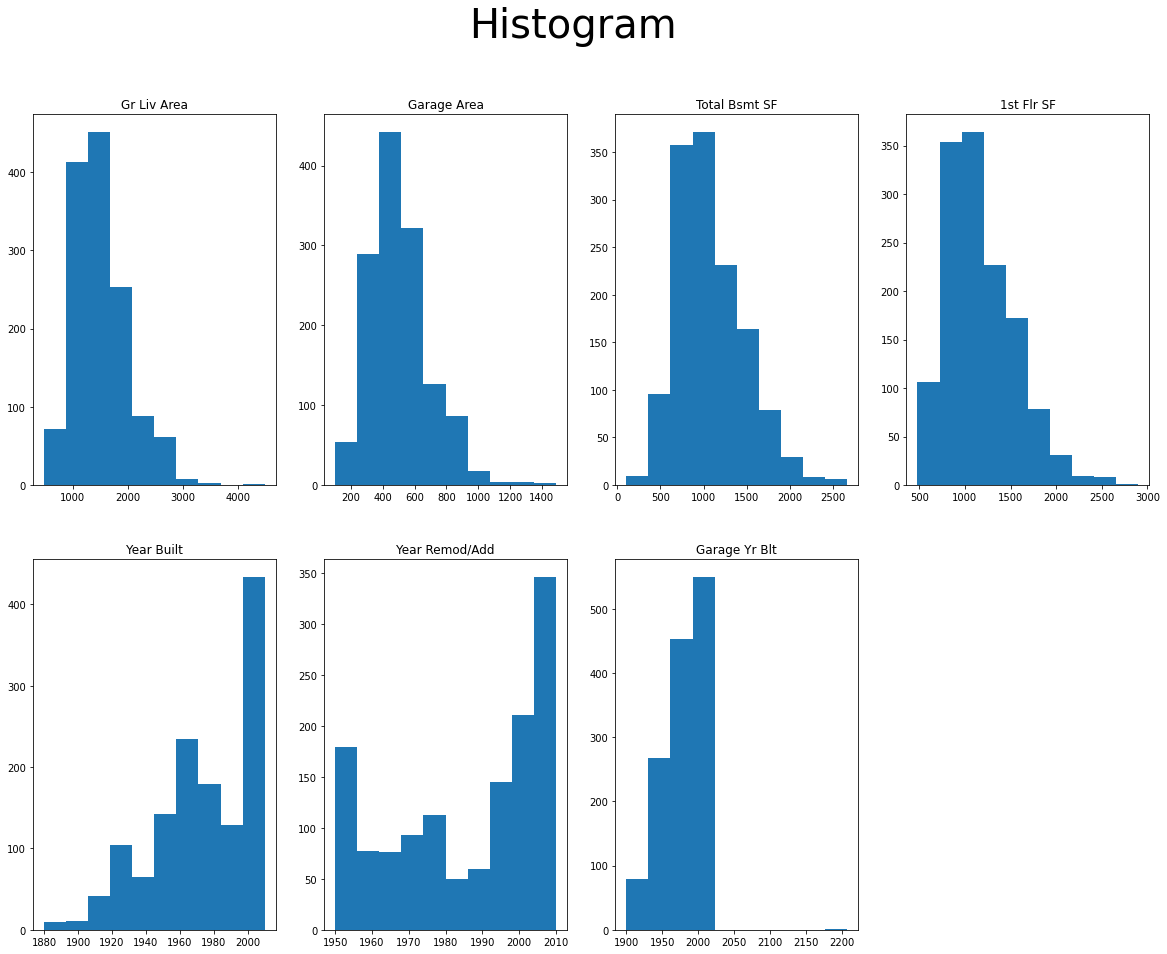

In [76]:
continuous_names = ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt']

plt.figure(figsize=(20,15))
plt.suptitle("Histogram", fontsize=40)

for i in range(len(continuous_names)):
    plt.subplot(2,4,i+1)
    plt.title(continuous_names[i])
    plt.hist(train[continuous_names[i]])

연속형 변수별 히스토그램입니다. 대체로 면적 변수는 오른쪽 꼬리가 긴 형태이며 연도 변수는 최근 년도의 빈도가 높은 모습입니다.

차고 완공 연도 변수의 경우 2200의 값이 있는데 연도 변수이므로 이상치로 생각해야겠습니다.

In [77]:
train[train['Garage Yr Blt'] > 2020]

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
254,255,1.5,1564,0,0,502,1,1546,1564,0,1,2006,2007,2207,267300


이상치로 추정되는 변수를 직접 관찰해보면 리모델링된 년도가 2007년 이므로 2007년 입력을 잘못해 2207로 입력한 것 같아요.

이에 맞게 수정해주었습니다.

In [78]:
train['Garage Yr Blt'][train['Garage Yr Blt'] > 2020] = 2007

In [80]:
train[train['id'] == 255] #잘 적용된 것을 확인

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
254,255,1.5,1564,0,0,502,1,1546,1564,0,1,2006,2007,2007,267300


# 연속형 변수 상관계수 행렬

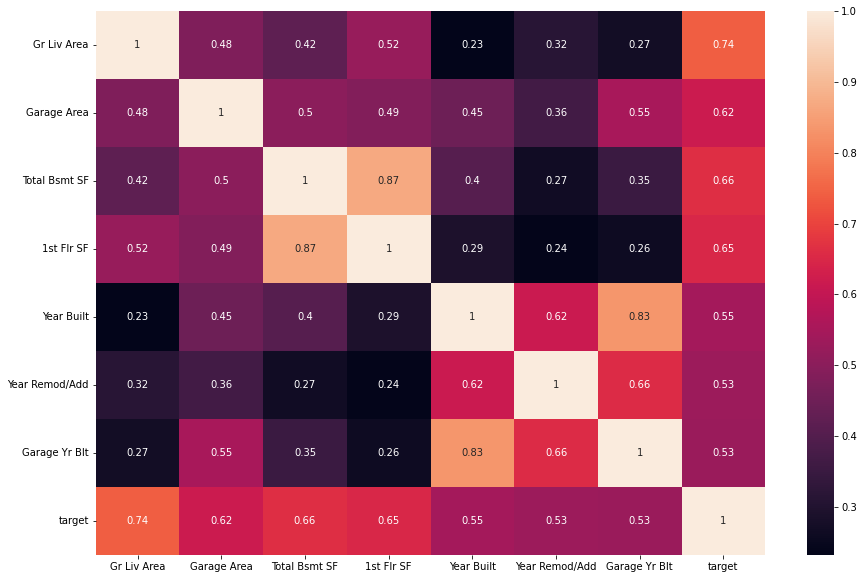

In [81]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(train[continuous_names+['target']].corr(), annot=True)
plt.show()

전반적으로 상관계수가 상당히 높은 편입니다. 특히 면적과 연도를 나타내는 변수끼리 상관계수가 높습니다.

먼저 눈에 띄는 부분은 Total Bsmt SF 와 1st Flr SF의 상관계수가 0.87로 너무나도 높다는 점 입니다. 이후에 자세히 관찰해보죠.

또 완공 년도와 리모델링 년도/차고 완공 년도 간 상관계수도 상당히 높은 편인데 이것 또한 자세히 살펴보겠습니다.

# 면적 변수들

In [82]:
print(sum(train['Total Bsmt SF'] > train['1st Flr SF']))
print(sum(train['Total Bsmt SF'] == train['1st Flr SF']))
print(sum(train['Total Bsmt SF'] < train['1st Flr SF']))

print(train['target'][train['Total Bsmt SF'] > train['1st Flr SF']].mean())
print(train['target'][train['Total Bsmt SF'] == train['1st Flr SF']].mean())
print(train['target'][train['Total Bsmt SF'] < train['1st Flr SF']].mean())

41
690
619
225367.0487804878
178311.39420289855
192849.1292407108


Total Bsmt SF 변수는 지상층 넓이, 1st Flr SF 변수는 1층 넓이 라고 소개되어 있습니다.

직관적으로 생각했을때 지상층 넓이가 1층, 2층까지 포함하는게 아닌가 생각했는데 데이터를 관찰하니 예상과 다른 결과가 나옵니다.

지상층 넓이 > 1층 넓이에 해당하는 개수가 41개로 매우 적고 두 변수가 같은 경우가 690개, 지상층 < 1층 개수는 619개 입니다.

잘 이해가 되지 않는 결과인데, 세 집단간 집 값의 평균값이 유의미하게 차이나는 것으로 관찰됩니다.

지상층 > 1층, 지상층 == 1층, 지상층 < 1층 세 그룹으로 나눈 변수를 추가하는 것도 괜찮을 것 같아요.

또 두 변수간 상관계수가 높기 때문에 한 변수만 써야하는데, 타겟 값과 상관계수가 조금 높은 Total Bsmt SF 변수를 사용하겠습니다.

In [83]:
train['1st Flr SF'][train['Total Bsmt SF'] > train['1st Flr SF']] = -1
train['1st Flr SF'][train['Total Bsmt SF'] == train['1st Flr SF']] = 0
train['1st Flr SF'][train['Total Bsmt SF'] < train['1st Flr SF']] = 1

train.rename(columns={'1st Flr SF':'1st - Total'}, inplace=True)

test['1st Flr SF'][test['Total Bsmt SF'] > test['1st Flr SF']] = -1
test['1st Flr SF'][test['Total Bsmt SF'] == test['1st Flr SF']] = 0
test['1st Flr SF'][test['Total Bsmt SF'] < test['1st Flr SF']] = 1

test.rename(columns={'1st Flr SF':'1st - Total'}, inplace=True)

1st Flr SF 변수를 활용하여 원하는 코딩을 했습니다.

# 연도 변수들

In [84]:
print(sum(train['Year Built'] == train['Year Remod/Add']))
print(sum(train['Year Built'] > train['Year Remod/Add']))
print(sum(train['Year Built'] < train['Year Remod/Add']))

print(sum(train['Year Built'] == train['Garage Yr Blt']))
print(sum(train['Year Built'] > train['Garage Yr Blt']))
print(sum(train['Year Built'] < train['Garage Yr Blt']))

743
0
607
1075
11
264


완공 연도와 리모델링 연도가 같다면 리모델링이 없었고, 리모델링 연도가 크다면 리모델링이 있던 집입니다.

리모델링 연도가 더 작다, 즉 완공연도보다 리모델링이 더 빨랐다는 비 상식적인 데이터는 다행이 관찰되지 않습니다.

완공 연도와 차고 완공 연도가 같은 경우는 1075개로 매우 많은 것이 두 변수에 상관계수 관찰에서 높은 값(0.83)의 이유인 것 같습니다.

특이하게 차고 완공 연도가 완공 연도보다 이른 데이터가 11개 있는데 차고를 미리 지은 집으로 생각할 수 있습니다.

다만 개수가 작기 때문에 차고 완공 연도와 완공 연도가 같은 경우와 같게 생각을 하겠습니다.

In [85]:
print(train['target'][train['Year Built'] < train['Year Remod/Add']].mean())
print(train['target'][train['Year Built'] == train['Year Remod/Add']].mean())

print(train['target'][train['Year Built'] < train['Garage Yr Blt']].mean())
print(train['target'][train['Year Built'] >= train['Garage Yr Blt']].mean())

183097.6589785832
189109.34454912518
151515.625
194888.02670349908


리모델링을 한 주택과 안한 주택간 집 값 차이가 약 6천으로 크진 않으나 표본이 743, 607이기 때문에 유의미 하다고 생각하겠습니다.

또 차고 완공 연도가 늦은 주택의 경우 집 값이 다소 낮은 것으로 관찰됩니다.

두 요소를 각각 변수로 만들고, 집 값 변수와 상관계수가 가장 높은 완공 연도 변수를 제외하고 나머지 두 변수는 사용하지 않겠습니다.

In [86]:
train['Year Remod/Add'][train['Year Built'] < train['Year Remod/Add']] = -1
train['Year Remod/Add'][train['Year Built'] == train['Year Remod/Add']] = 1
train.rename(columns={'Year Remod/Add':'Remod'}, inplace=True)

train['Garage Yr Blt'][train['Year Built'] >= train['Garage Yr Blt']] = 1
train['Garage Yr Blt'][train['Year Built'] < train['Garage Yr Blt']] = -1
train.rename(columns={'Garage Yr Blt':'Garage'}, inplace=True)

test['Year Remod/Add'][test['Year Built'] < test['Year Remod/Add']] = -1
test['Year Remod/Add'][test['Year Built'] == test['Year Remod/Add']] = 1
test.rename(columns={'Year Remod/Add':'Remod'}, inplace=True)

test['Garage Yr Blt'][test['Year Built'] >= test['Garage Yr Blt']] = 1
test['Garage Yr Blt'][test['Year Built'] < test['Garage Yr Blt']] = -1
test.rename(columns={'Garage Yr Blt':'Garage'}, inplace=True)

In [87]:
train['Remod'].value_counts()

 1    743
-1    607
Name: Remod, dtype: int64

In [88]:
train['Garage'].value_counts()

 1    1086
-1     264
Name: Garage, dtype: int64

앞선 방식과 비슷하게 코딩했습니다. value_counts 함수를 통해 원하는 목적대로 코드가 작동했는지 확인했습니다.

# 데이터 전처리

In [89]:
from sklearn.preprocessing import StandardScaler

continuous_names = ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Year Built']

scaler = StandardScaler()

train_scaler = scaler.fit_transform(train[continuous_names])
train[continuous_names] = pd.DataFrame(data=train_scaler, columns=continuous_names)

test_scaler = scaler.transform(test[continuous_names])
test[continuous_names] = pd.DataFrame(data=test_scaler, columns=continuous_names)

남은 연속형 변수들을 모두 표준화 시켜줍니다. 표준화의 장점은 변수 간 스케일 차이가 모델에 영향을 주지 않기 위함인데요.

머신러닝 방식에 따라 표준화가 반드시 필요할 수도 있고 아닐수도 있지만, 모든 머신러닝 방식에 적용하기 위해 표준화를 시켜줬습니다. 

이전에 범주형 변수에서도 레이블 인코딩 방식을 적용할때 평균을 0에 가까이 하기 위해 노력한 것도 표준화의 일종입니다.

또 중요한 점이 스케일링을 진행할 때 테스트 데이터는 모르는 상태로 진행해야한다는 것 입니다.

그래서 스케일러를 만들때는 트레인 데이터만을 사용해서 만들었고, 테스트 데이터는 스케일러에 적용만 했습니다.

이 부분에 더 자세한 설명은 제 이전글을 참고하시면 좋을 것 같아요!

In [90]:
train.describe()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st - Total,Bsmt Qual,Full Bath,Year Built,Remod,Garage,target
count,1350.000000,1350.000000,1.350000e+03,1350.000000,1350.000000,1.350000e+03,1350.000000,1.350000e+03,1350.000000,1350.000000,1350.000000,1.350000e+03,1350.000000,1350.000000,1350.000000
mean,675.500000,-0.291852,-2.289527e-16,-0.568148,-0.139259,-6.315935e-17,-0.426667,1.342136e-16,0.428148,-0.370370,0.084444,3.067176e-15,0.100741,0.608889,186406.312593
std,389.855743,1.287020,1.000371e+00,0.564078,0.626697,1.000371e+00,0.635169,1.000371e+00,0.552996,0.657293,0.996797,1.000371e+00,0.995281,0.793549,78435.424758
min,1.000000,-2.500000,-2.120771e+00,-1.000000,-1.000000,-2.101280e+00,-1.000000,-2.546444e+00,-1.000000,-1.000000,-1.000000,-3.174022e+00,-1.000000,-1.000000,12789.000000
25%,338.250000,-1.500000,-7.582801e-01,-1.000000,-1.000000,-7.004781e-01,-1.000000,-6.945214e-01,0.000000,-1.000000,-1.000000,-6.139801e-01,-1.000000,1.000000,135000.000000
50%,675.500000,-0.500000,-1.396189e-01,-1.000000,0.000000,-9.416111e-02,-1.000000,-1.918197e-01,0.000000,0.000000,1.000000,1.028315e-01,1.000000,1.000000,165375.000000
75%,1012.750000,0.500000,5.354708e-01,0.000000,0.000000,4.494335e-01,0.000000,5.908844e-01,1.000000,0.000000,1.000000,9.903125e-01,1.000000,1.000000,217875.000000
max,1350.000000,2.500000,6.078799e+00,1.000000,1.000000,5.153617e+00,1.000000,4.108494e+00,1.000000,1.000000,1.000000,1.263384e+00,1.000000,1.000000,745000.000000


모든 변수가 이쁘게 표준화 된 것을 확인할 수 있습니다.

In [91]:
train_label = np.log1p(train['target'])
train.drop(['target', 'id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

목푯값을 로그변환 한 뒤 따로 저장해주고, 의미없는 id 변수는 제거해줍니다.

# 간단한 모델 적합

In [103]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 0, n_estimators = 100)
rf.fit(train,train_label)
sample_submission['target'] = np.expm1(rf.predict(test))

sample_submission.to_csv('house_1.csv',index=False)

간단한 랜덤포레스트 회귀 모델을 사용했습니다.

리더보드 결과는 0.103정도 나옵니다. 다른 모델을 사용하거나, 앙상블을 진행한다면 더 좋은 결과가 나올 것으로 기대됩니다!

In [104]:
sample_submission

,id,target
0,1,325618.546941
1,2,126797.873590
2,3,180281.798084
3,4,217353.116185
4,5,128285.894786
...,...,...
1345,1346,312374.089659
1346,1347,127948.517488
1347,1348,84663.887853
1348,1349,210368.189894
